In [1]:
#Classify the images from the CIFAR-10 dataset. The dataset consists of airplanes, dogs, cats, and other objects. 
#Preprocess the images, then train a convolutional neural network on all the samples.
#The images need to be normalized and the labels need to be one-hot encoded. 
#Build a convolutional, max pooling, dropout, and fully connected layers. 
#See your neural network's predictions on the sample images.

#Import the required libraries
import numpy as np
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import pickle
import tensorflow as tf
import random
import image_helper as helper
import unit_test as tests

%matplotlib inline

In [2]:
#Load the dataset
cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

#Test if all the images are loaded
tests.test_folder_path(cifar10_dataset_folder_path)

All files found!



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 4:
Image - Min Value: 0 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


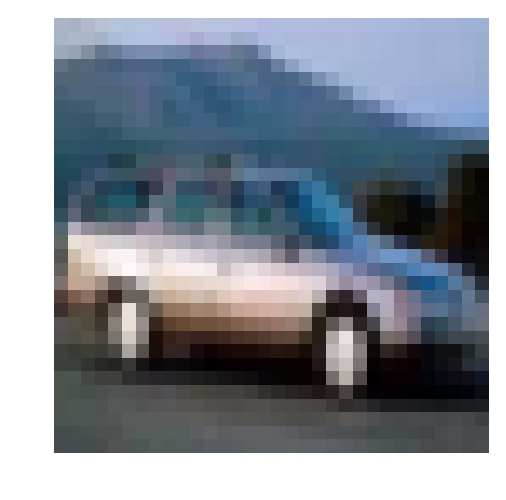

In [3]:
#Explore the dataset

%config InlineBackend.figure_format = 'retina'

batch_id = 1
sample_id = 4
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [4]:
#Define normalize function to take image data x as inptu and return it as a normalized Numpy array

def normalize(x):
    return x / 255 # x - np.min(x) / (np.max(x) - np.min(x))

In [5]:
#Define on_hot_encode function to take input, x, a list of labels. The function returns the list of labels as One-Hot encoded Numpy array

def one_hot_encode(x):
    z = np.zeros((len(x), 10))
    z[list(np.indices((len(x),))) + [x]] = 1
    return z

In [6]:
# Preprocess Training, Validation, and Testing Data

helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


In [7]:
#Load the preprocessed validation data

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [8]:
#Implement functions for the neural network to read the image data, one-hot encoded labels, and dropout keep probability.

def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, shape=(None,)+image_shape, name='x')


def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=(None, n_classes), name='y')


def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, name='keep_prob')

tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


In [9]:
#Define the function to apply Convulational and then Max-Pooling layear
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    # Weight and bias
    weight = tf.Variable(tf.truncated_normal([*conv_ksize, x_tensor.shape.as_list()[3], conv_num_outputs],stddev=5e-2))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    # Apply Convolution
    conv_layer = tf.nn.conv2d(x_tensor,
                              weight,
                              strides=[1, *conv_strides, 1],
                              padding='SAME')
    # Add bias
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    # Apply activation function
    conv_layer = tf.nn.relu(conv_layer)
    
    # Apply Max Pooling
    conv_layer = tf.nn.max_pool(conv_layer,
                                ksize=[1, *pool_ksize, 1],
                                strides=[1, *pool_strides, 1],
                                padding='SAME')
    
    return conv_layer

tests.test_con_pool(conv2d_maxpool)

Instructions for updating:
Colocations handled automatically by placer.
Tests Passed


In [10]:
#Implement the flatten function to change the dimension of x_tensor from a 4-D tensor to a 2-D tensor
def flatten(x_tensor):
   return tf.contrib.layers.flatten(x_tensor)

tests.test_flatten(flatten)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Tests Passed


In [11]:
#Implement the fully_conn function to apply a fully connected layer to x_tensor with the shape (Batch Size, num_outputs)
def fully_conn(x_tensor, num_outputs):
   return tf.layers.dense(x_tensor, num_outputs, activation=tf.nn.relu)

tests.test_fully_conn(fully_conn)

Instructions for updating:
Use keras.layers.dense instead.
Tests Passed


In [12]:
#Implement the output function to apply a fully connected layer to x_tensor with the shape (Batch Size, num_outputs)
def output(x_tensor, num_outputs):
    return tf.layers.dense(x_tensor, num_outputs)

tests.test_output(output)

Tests Passed


In [13]:
#Implement the function conv_net to create a convolutional neural network model. The function takes in a batch of images, x, and outputs logits. Use the layers created above to create this model:

#Apply 1, 2, or 3 Convolution and Max Pool layers
#Apply a Flatten Layer
#Apply 1, 2, or 3 Fully Connected Layers
#Apply an Output Layer
#Return the output

def conv_net(x, keep_prob):
   
    #Apply Convolution and Max Pool layers
    x = conv2d_maxpool(x, 64, (5, 5), (1, 1), (3, 3), (2, 2)) # 14x14x64
    x = tf.layers.dropout(x, rate=keep_prob)
    x = conv2d_maxpool(x, 64, (5, 5), (1, 1), (3, 3), (2, 2)) # 7x7x64
    x = tf.layers.dropout(x, rate=keep_prob)
    
    #Apply a Flatten Layer
    x = flatten(x)
    
    #Apply Fully Connected Layers
    x = fully_conn(x, 384)
    x = fully_conn(x, 192)
    
    
    #Apply an Output Layer
    # Set this to the number of classes
    x = output(x, 10)
    
    #Return output
    return x

#Build the Neural Network
#Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

#Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

#Model
logits = conv_net(x, keep_prob)

#Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

#Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

#Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)


Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Neural Network Built!


In [14]:
#Implement the function train_neural_network to do a single optimization.
#The optimization should use optimizer to optimize in session with a feed_dict of the following:
#x for image input
#y for labels
#keep_prob for keep probability for dropout

def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: keep_probability})

tests.test_train_nn(train_neural_network)

Tests Passed


In [15]:
#Implement the function print_stats to print loss and validation accuracy. 
#Use the global variables valid_features and valid_labels to calculate validation accuracy. 
#Use a keep probability of 1.0 to calculate the loss and validation accuracy

def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: 1.})
    valid_acc = sess.run(accuracy, feed_dict={
        x: valid_features,
        y: valid_labels,
        keep_prob: 1.})

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
        loss,
        valid_acc))

In [16]:
#Tune Parameters
#Running with only 25 epochs and batch size 100 as my machine shuts down automatically on increasing the number
epochs = 25
batch_size = 100
keep_probability = 0.75

In [17]:
#Train on a Single CIFAR-10 Batch
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.8263 Validation Accuracy: 0.411600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.5968 Validation Accuracy: 0.484400
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.4115 Validation Accuracy: 0.526200
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.2157 Validation Accuracy: 0.553400
Epoch  5, CIFAR-10 Batch 1:  Loss:     0.9964 Validation Accuracy: 0.571200
Epoch  6, CIFAR-10 Batch 1:  Loss:     0.8564 Validation Accuracy: 0.563800
Epoch  7, CIFAR-10 Batch 1:  Loss:     0.8247 Validation Accuracy: 0.564000
Epoch  8, CIFAR-10 Batch 1:  Loss:     0.7219 Validation Accuracy: 0.575800
Epoch  9, CIFAR-10 Batch 1:  Loss:     0.6893 Validation Accuracy: 0.573400
Epoch 10, CIFAR-10 Batch 1:  Loss:     0.6817 Validation Accuracy: 0.539600
Epoch 11, CIFAR-10 Batch 1:  Loss:     0.4618 Validation Accuracy: 0.584000
Epoch 12, CIFAR-10 Batch 1:  Loss:     0.3442 Validation Accuracy: 0.574200
Epoch 13, CIFAR-10 Batch 1:  Loss:     0.2119

In [18]:
#Train with all the batches
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    #Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    #Training cycle
    for epoch in range(epochs):
        #Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    #Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.8064 Validation Accuracy: 0.426400
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.3320 Validation Accuracy: 0.506200
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.0284 Validation Accuracy: 0.562000
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.1761 Validation Accuracy: 0.580000
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.0178 Validation Accuracy: 0.586000
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.3724 Validation Accuracy: 0.576600
Epoch  2, CIFAR-10 Batch 2:  Loss:     0.8796 Validation Accuracy: 0.612800
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.7650 Validation Accuracy: 0.644200
Epoch  2, CIFAR-10 Batch 4:  Loss:     0.9538 Validation Accuracy: 0.637000
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.7959 Validation Accuracy: 0.654200
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.0519 Validation Accuracy: 0.647000
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.7222 Validation Accuracy: 0.644400
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.6446 Validation Accuracy: 0.676200


Epoch 22, CIFAR-10 Batch 3:  Loss:     0.0224 Validation Accuracy: 0.687400
Epoch 22, CIFAR-10 Batch 4:  Loss:     0.0355 Validation Accuracy: 0.685000
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.0208 Validation Accuracy: 0.694000
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.0391 Validation Accuracy: 0.679000
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.0602 Validation Accuracy: 0.678000
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.0328 Validation Accuracy: 0.708000
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.0269 Validation Accuracy: 0.694200
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.0244 Validation Accuracy: 0.703600
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.0291 Validation Accuracy: 0.671800
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.0150 Validation Accuracy: 0.684600
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.0254 Validation Accuracy: 0.700800
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.0150 Validation Accuracy: 0.702600
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.0083 Validation Accuracy: 0.713200
Epoch 25, CI

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6910000002384186



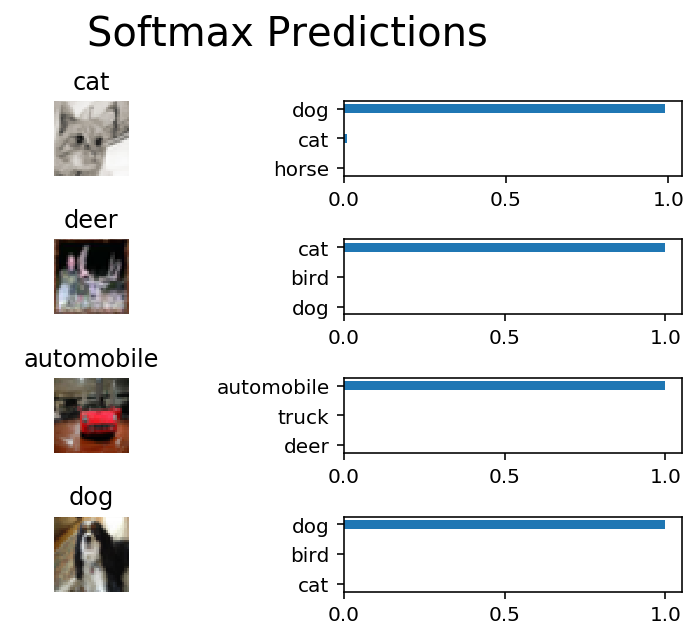

In [20]:
#Test the model against the test dataset.
#Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 100

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        #Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        #Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        #Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        #Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()
